# The human body glyceamia (blood sugar) and insulin model

This notebook contains an abstract model of the human body glyceamia system which regulates blood sugar in the human body. The primary processes of this model are digestion which increase blood sugar, and the release of insulin from the pancreas which decreases insulin. This model explores how spacing different meals throughout the day, and modulating the glycemic load of meals will have a different effect on the stability of ones blood sugar level and the amount of insulin released.

In order to use the model we must make some assumptions about the dynamical system of glyceamia, these assumptions include that digestion is the primary system that increases blood sugar in the body and that insulin is the primary system that reduces blood sugar in the body. There are many factors that can additionally be integrated into this model such as excercise and the function of other organs and hormones in the body. Since we cannot know for certain what to exepct from things we cannot control, we can do our best to design and parameterize the protocoll such that it behaves acceptably accross a broad range of simulated situations. 

## The Model 

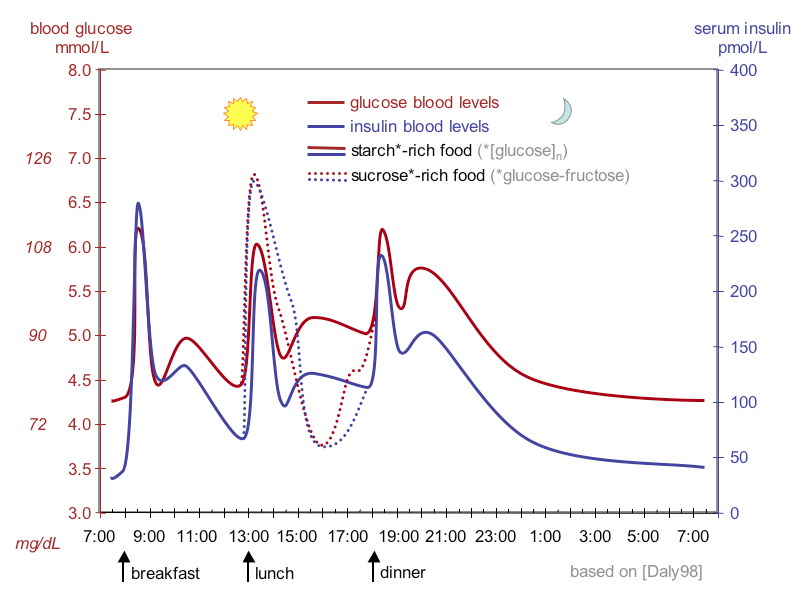

We base our initial model off of the above image. 

**Glucose blood levels** are measured in mille moles / litre (mmol/L) in the range of 3-8 mmol/L, initialized at 4. **Insulin blood levels** are measured in picomoles / litre (pmol/L) in the range of 0-400 pmol/L, initialized at 50. In addition to tracking current glucose blood levels and insulin levels, we track **current glycemic load**, and **total glucose metabolised**, each measured in grams. Where glycemic load is the equivilent of number of grams of glucose currently being digested, and total glucose metabolised is the integral of glycemic load up to the current point. Glycemic load is how glucose enters the system, it is then converted into blood glucose which raises the glyceama of the body, and is then nutralized by insulin through metabolic functions. 

## State

| Name | Symbol | Definition | Description | initial value | Unit |
| -------- | -------- | -- | -------- | -- | -- |
| glycemia | $G$ | -- | Blood Glucose Level | 4.0 | mmol/L |
| insulin | $I$ | -- | Blood Insulin Level | 50.0 | pmol/L |
| glycemic_load | $L$ | -- | Glucose equivalent carbs being digested | 0 | g |
| glucose_metabolised | $M$ | -- | Total glucose that has been digested and metabolized | 0 | g |

## Parameters

| Name | Symbol | Definition | Description | initial value | Unit |
| -------- | -------- | -------- | -- | -- | -- |
| meals_per_day | $\mathcal{M}$ | -- | Set of meals eaten per day, where each meal maps to a function that returns a glycemic load in grams. | {'Lunch', 'Dinner'} | {f()=>g}  |
| blood_volume | $I$ | -- | Volume of blood contained in the subjects body | 5 | L |

### Meals Per Day

In our modelling we are interested in the effect of different diets on our blood sugar levels and insulin release. In this parameter we can pass a list of meals that the human is consuming every day, this can be any combination of 'Breakfast', 'Lunch', and 'Dinner', of which we can modulate the effect of each meal in the digestion policy. Additional meals, snacks, or diets can be added by expanding the digestion policy and adding respective keywords to this parameter. *In a future iteration we may want to separate digestion policy from diet policy.* 

### Blood Volume

Blood volume is used for the conversion of absolute grams of glucose to mmol/L glucose blood levels. The higher our blood volume, the more glucose is needed to raise our mmol/L blood glucose level. This parameter could potentially be used as a proxy for general insulin sensitivity. 

## Planned Analysis

1. Use a historic average for outflow rate, a target reserve ratio of `0.2`, a throttle of `0.008` which works out to be 9.6% per year, variance of `0.25` and pull of `0.75`, determine a range of producitivity values where the trend of market saturation is bellow 0.1 and above 0.8.
2. Using the median value in that range for productivity, and do a parameter sweep of target reserve ratio from `0.1` and `0.3`in increments of `0.025`, and throttle beteen `0.002` and `0.032` in increments of `0.004`. Plot the market saturation trend and compare between simulations. 
3. Narrow the bounds of reserve and throttle and add parameter sweeps for productivity, variance, and pull. 
    
Use a heatmap for each variation of reserve and throttle, showing final market saturation and one for price using throttle and reserve as the x and y axis and color coding to represent value. 


In [1]:
import random as rand
import numpy as np 

# Genesis States

In [2]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'glyceamia': 4.0, # Current blood sugar level in mmol/L
    'insulin': 50, # Current blood insulin level in pmol/L
    'glycemic_load': 0, # Load of glucose being digested
    'glucose_metabolised': 0, # Total glucose that has been metabolised
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Model Params
We define some parameters which can be used to tune the behavior of issuance and distribution in the model. Paramters assume that each time step of the model relfect 1 month of real time, the simulation will run for 120 timesteps giving the model as a whole a 10 year time horizon.  

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
params = {
    'meals_per_day': [['Lunch', 'Dinner']],
    'blood_volume': [5], # Litres of blood in the subject
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Timestep
We assume that each timestep in cadcad represents 15 minutes in real time, scaling model parameters to reflect that timescale. 

# Policies and State Update Functions

We define a supply policy and four state update fuctions. 


In [44]:
# Constants

# One timestep = 15 minutes
TIMESTEP_PER_DAY = 4*24 

# Breakfast = 8:30am
# Lunch = 12:00pm
# Dinner = 6:00pm
BREAKFAST = 4 * 8 + 2
LUNCH = 4 * 12
DINNER = 4 * 18

# Glycemic Loads of Meals
BREAKFAST_LOAD = 10
LUNCH_LOAD = 20
DINNER_LOAD = 15

# Exponential Decay Rate of D
GLYCEMIC_DECAY = 4

def diet_policy(params, step, sH, s):
    # Eat according to time of day and meals_per_day param
    current_timestep = len(sH)
    time_of_day = current_timestep % TIMESTEP_PER_DAY
    
    if (time_of_day == BREAKFAST) and ('Breakfast' in params['meals_per_day']):
        # Time to eat breakfast
#         return ({'glycemic_load': np.random.randint(1,25) + s['glycemic_load']})
        return ({'glycemic_load': BREAKFAST_LOAD + s['glycemic_load']})
        
    if (time_of_day == LUNCH) and ('Lunch' in params['meals_per_day']):
        # Time to eat lunch
#         return ({'glycemic_load': np.random.randint(1,25) + s['glycemic_load']})
        return ({'glycemic_load': LUNCH_LOAD + s['glycemic_load']})

    if (time_of_day == DINNER) and ('Dinner' in params['meals_per_day']):
        # Time to eat dinner
#         return ({'glycemic_load': np.random.randint(1,25) + s['glycemic_load']})
        return ({'glycemic_load': DINNER_LOAD + s['glycemic_load']})
    
    return ({'glycemic_load': s['glycemic_load']/4})

def digestion_policy(params, step, sH, s):
    # Convert a portion of glycemic load into blood glucose
    glucose_metabolised = s['glucose_metabolised']
    glycemic_load = s['glycemic_load']
    surplus = glycemic_load - glucose_metabolised
    surplus_mmol = surplus / (18 * params['blood_volume'])
    return ({'glyceamia': s['glyceamia'] + surplus_mmol})

def pancreas_policy(params, step, sH, s):
    # Check insulin to blood sugar ratio to decide whether to release more insulin
    blood_sugar = s['glyceamia']
    insulin_level = s['insulin']
    
    # Based on https://en.wikipedia.org/wiki/Blood_sugar_level
    threshold = (5 / 400) * insulin_level + 3
    if blood_sugar > threshold:
        return ({'insulin': s['insulin'] + 50})
    else:
        return ({'insulin': s['insulin'] - 10})

def metabolism_policy(params, step, sH, s):
    # If insulin in blood, metabolise glucose
    blood_sugar = s['glyceamia']
    insulin = s['insulin']
    insulin_rate = insulin / 400
    glucose_metabolised_mmol = blood_sugar * insulin_rate
    glucose_metabolised_grams = glucose_metabolised_mmol * 18 * params['blood_volume'] / 1000
    return ({'glucose_metabolised': glucose_metabolised_grams})

def update_glyceamia(params, step, sH, s, _input):
    return ('glyceamia', _input['glyceamia'])
    
def update_insulin(params, step, sH, s, _input):
    return ('insulin', _input['insulin'])
    
def update_glycemic_load(params, step, sH, s, _input):
    return ('glycemic_load', _input['glycemic_load'])
    
def update_glucose_metabolised(params, step, sH, s, _input):
    return ('glucose_metabolised', s['glucose_metabolised'] + _input['glucose_metabolised'])

# Partial State Update Blocks


In [45]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    { 
        'policies': {
            'diet_policy': diet_policy,
            'digestion_policy': digestion_policy,
            'pancreas_policy': pancreas_policy,
            'metabolism_policy': metabolism_policy,

        },
        'variables': { # The following state variables will be updated simultaneously
            'glyceamia': update_glyceamia,
            'insulin': update_insulin,
            'glycemic_load': update_glycemic_load,
            'metabolised': update_glucose_metabolised,
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Simulation Configuration Parameters
Lastly, we define the number of timesteps and the number of Monte Carlo runs of the simulation. These parameters must be passed in a dictionary, in `dict_keys` `T` and `N`, respectively. In our example, we'll run the simulation for 10 timesteps. And because we are dealing with a deterministic system, it makes no sense to have multiple Monte Carlo runs, so we set `N=1`. We'll ignore the `M` key for now and set it to an empty `dict`

In [46]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's omit it
sim_config_dict = {
    'T': range(4*24*6), # One Week
    'N': 1, # Four Runs
    'M': params
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Putting it all together
We have defined the state variables of our system and their initial conditions, as well as the state update functions, which have been grouped in a single state update block. We have also specified the parameters of the simulation (number of timesteps and runs). We are now ready to put all those pieces together in a `Configuration` object.

In [47]:
#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
del configs[:]
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

# Running the engine
We are now ready to run the engine with the configuration defined above. Instantiate an ExecutionMode, an ExecutionContext and an Executor objects, passing the Configuration object to the latter. Then run the `execute()` method of the Executor object, which returns the results of the experiment in the first element of a tuple.

In [48]:
%%capture
from cadCAD.engine import ExecutionMode, ExecutionContext
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

from cadCAD.engine import Executor

simulation = Executor(exec_context=local_mode_ctx, configs=configs) # Pass the configuration object inside an array

In [49]:
raw_system_events, tensor_field, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (576, 2, 1, 4)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.03s


# Analyzing the results
We can now convert the raw results into a DataFrame for analysis

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
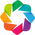

In [50]:
import pandas as pd
import hvplot.pandas
import holoviews as hv
import panel as pn
hv.extension('bokeh')

In [51]:
df = pd.DataFrame(raw_system_events)
df

,glyceamia,insulin,glycemic_load,glucose_metabolised,simulation,subset,run,substep,timestep
0,4.000000,50,0.000000e+00,0.000000,0,0,1,0,0
1,4.000000,100,0.000000e+00,0.045000,0,0,1,1,1
2,3.999500,90,0.000000e+00,0.135000,0,0,1,1,2
3,3.998000,80,0.000000e+00,0.215990,0,0,1,1,3
4,3.995600,70,0.000000e+00,0.287954,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...
572,-1.334871,-330,1.364242e-11,4.087197,0,0,1,1,572
573,-1.380285,-340,3.410605e-12,4.186311,0,0,1,1,573
574,-1.426799,-350,8.526513e-13,4.291903,0,0,1,1,574
575,-1.474487,-360,2.131628e-13,4.404264,0,0,1,1,575


### Selector

In [52]:
# curve_dict = {column: df.hvplot.line(y=column, by='run', x='timestep') for column in set(df.columns)-{'run','timestep','subset','substep','simulation'}}
# selector = hv.HoloMap(curve_dict)
# selector

### Gridspec

In [53]:
from holoviews import opts

curve_dict = {column: df.hvplot.line(y=column, by='run', x='timestep',alpha=1, width=600, height=250) for column in set(df.columns)-{'run','timestep','subset','substep','simulation'}}
holomap = hv.HoloMap(curve_dict)

grid = hv.GridSpace(holomap)

ndlayout = hv.NdLayout(grid)
grid = ndlayout.cols(2)
grid

:NdLayout   [Default]
   :NdOverlay   [run]
      :Curve   [timestep]   (insulin)

### Overlay

In [54]:
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm.hvplot.line(x='timestep', y=['glyceamia', 'insulin', 'glycemic_load', 'glucose_metabolised'])

:NdOverlay   [Variable]
   :Curve   [timestep]   (value)

So far:
* Mindful of cadCAD version `pip install cadCAD==0.4.23` See here https://github.com/cadCAD-org/cadCAD/issues/301 
* Mindful of jupyter lab version because global undo is super annoying `pip install "jupyterlab<3.1"` See here https://stackoverflow.com/questions/68763795/how-to-undo-redo-changes-inside-the-selected-cell-in-jupyter-notebook 

Currently comparing runs for each variable. Further steps:
1. Make 'timestep' sensible in terms of days
2. ~Multi y-axis to compare all variables~
3. ~One run at a time~
4. Averaging runs
5. ~Constant meals~

Tools Required 
* ~Jupyter Documentation~
* Mathematical specification
* What-if matrix

Advanced Topics:
* Functional Programming
* Agent Modelling
* Class based modelling
* Interactive Models

exp2 Changelog:  
* digestion_policy => diet_policy
* glycemia_policy => digestion_policy
* insulin_policy => pancreas_policy
* Removed the randomness in the diet policy to give consistent glycemic loads per meal. 
* Reduce runs to 1
* Plot a normalized overlay of all the stocks